# COMP 432 Project


## Setup
- Ensure that in your google drive downloaded the csv file at: https://drive.google.com/file/d/1tqOWDft3DkX3hXEjUDYtAKnKPhmk6o4r/view?usp=sharing
- Ensure that you are the directory with the cvs file
- Make sure to run all the cells in order

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from joblib import dump, load
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/COMP_432_Project

/content/drive/MyDrive/COMP_432_Project


In [ ]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
fer2013 = pd.read_csv('fer2013.csv')
emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


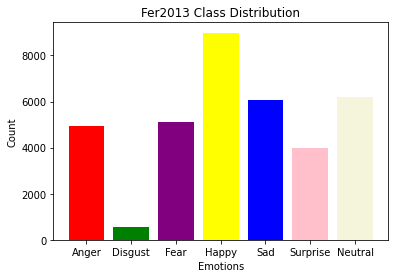

In [ ]:
counts = fer2013['emotion'].value_counts()
labels = fer2013['emotion'].value_counts().keys()
plt.title("Fer2013 Class Distribution")
plt.ylabel("Count")
plt.xlabel("Emotions")
plt.bar(labels, counts, color = ['yellow', 'beige', 'blue', 'purple', 'red', 'pink', 'green'])
plt.xticks(labels.sort_values(), ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
plt.show()

In [ ]:
X_train, y_train = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
X_val, y_val = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
X_test, y_test = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

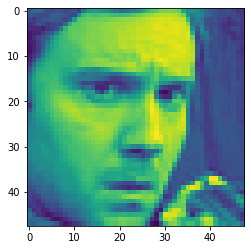

In [ ]:
plt.imshow(X_train[0])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(28709, 48, 48)
(3589, 48, 48)
(3589, 48, 48)


## Results

- Some unsupervised were trained out of curiosity, their results are turned out to be interpretable
- Some model might not be able to ran one after the other if the data had been transformed and requires being reset
- SVM does take quite a while to output results

### Logistic Regression

In [ ]:
logistic_clf = load('models/best_log.joblib')

X_train_log = X_train.reshape(X_train.shape[0],-1)
X_val_log = X_val.reshape(X_val.shape[0],-1)
X_test_log = X_test.reshape(X_test.shape[0],-1)

X_train_log = X_train_log/255
X_val_log = X_val_log/255
X_test_log = X_test_log/255

In [ ]:
print('Accuracy')
print('Training: ' + str(logistic_clf.score(X_train_log,y_train)))
print('Validation: ' + str(logistic_clf.score(X_val_log,y_val)))
print('Test: ' +  str(logistic_clf.score(X_test_log,y_test)))

print('Balanced Accuracy')
print('Training: ' + str(balanced_accuracy_score(y_train, logistic_clf.predict(X_train_log))))
print('Validation: ' + str(balanced_accuracy_score(y_val, logistic_clf.predict(X_val_log))))
print('Test: ' + str(balanced_accuracy_score(y_test, logistic_clf.predict(X_test_log))))

Accuracy
Training: 0.4058309241004563
Validation: 0.3839509612705489
Test: 0.3825578155475063
Balanced Accuracy
Training: 0.32542623789001307
Validation: 0.3053440897941413
Test: 0.29988475959989275


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


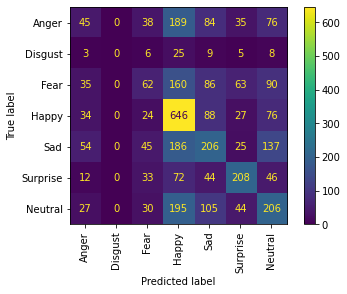

In [ ]:
sklearn.metrics.plot_confusion_matrix(logistic_clf, X_test_log, y_test, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], xticks_rotation=90);

In [ ]:
weights = logistic_clf.coef_

(7, 2304)


(-0.5, 47.5, 47.5, -0.5)

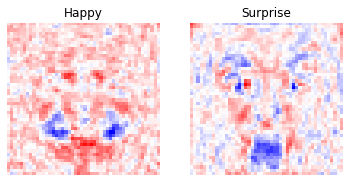

In [ ]:
weight_test = weights.reshape(7,48,48)
plt.subplot(1,2,1)
plt.title('Happy')
plt.imshow(weight_test[3], cmap='bwr')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Surprise')
plt.imshow(weight_test[5], cmap='bwr')
plt.axis('off')

### Kernel Density

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = X_train/255
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test/255
X_val = X_val.reshape(X_val.shape[0], -1)
X_val = X_val/255
kdeData = load('models/kde.joblib')
trainD = kdeData.score(X_train,y_train)
testD = kdeData.score(X_test, y_test)
valD = kdeData.score(X_val,y_val)

### Gaussian Mixtures

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = X_train/255
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test/255
X_val = X_val.reshape(X_val.shape[0], -1)
X_val = X_val/255
gmm_clf = load('models/gmm.joblib') 
trainGMM = gmm_clf.score(X_train,y_train)
testGMM = gmm_clf.score(X_test, y_test)
valGMM = gmm_clf.score(X_val,y_val)
print(trainGMM)
print(testGMM)
print(valGMM)

### Decision Tree

the accuracy score on the test data of the best decision tree estimator found using RandomSearchCV is: 31.039286709389803%
the balanced accuracy score on the test data of the best decision tree estimator found using RandomSearchCV is: 30.579626595355975%
the accuracy score on the training data of the best decision tree estimator found using RandomSearchCV is: 99.82932181545857%
the balanced accuracy score on the training data of the best decision tree estimator found using RandomSearchCV is: 99.81054395280464%
the accuracy score on the validation data of the best decision tree estimator found using RandomSearchCV is: 31.680133741989415%
the balanced accuracy score on the validation data of the best decision tree estimator found using RandomSearchCV is: 31.844186112861873%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


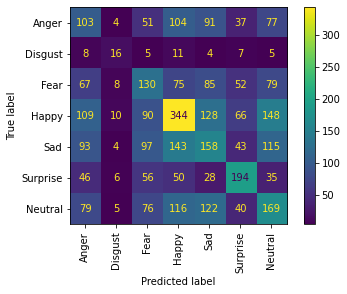

In [ ]:
tree_clf_grid_search = load('models/decision_tree_randomsearch.joblib')
print('the accuracy score on the test data of the best decision tree estimator found using RandomSearchCV is: ' + str(accuracy_score(y_test, tree_clf_grid_search.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the test data of the best decision tree estimator found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_test, tree_clf_grid_search.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the accuracy score on the training data of the best decision tree estimator found using RandomSearchCV is: ' + str(accuracy_score(y_train, tree_clf_grid_search.best_estimator_.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the training data of the best decision tree estimator found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_train, tree_clf_grid_search.best_estimator_.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the accuracy score on the validation data of the best decision tree estimator found using RandomSearchCV is: ' + str(accuracy_score(y_val, tree_clf_grid_search.best_estimator_.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the validation data of the best decision tree estimator found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_val, tree_clf_grid_search.best_estimator_.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
sklearn.metrics.plot_confusion_matrix(tree_clf_grid_search.best_estimator_, X_test.reshape(X_test.shape[0], -1), y_test, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], xticks_rotation=90);


([], <a list of 0 Text major ticklabel objects>)

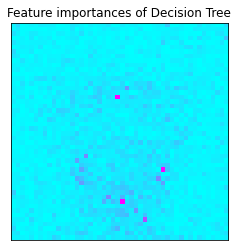

In [ ]:
"""
Plotting the feature importances of the best-performing Decision Tree,
"""
estimator = tree_clf_grid_search.best_estimator_
importances = estimator.feature_importances_
importances = importances.reshape(48, 48)
plt.imshow(importances[:, :], cmap='cool', interpolation='nearest')
plt.title('Feature importances of Decision Tree')
#Hide x and y ticks
plt.xticks([])
plt.yticks([])

### Random Forest

the accuracy score on the test data of the best forest estimator found using GridSearchCV is: 47.86848704374478%
the balanced accuracy score on the test data of the best forest estimator found using GridSearchCV is: 42.13069903899861%
the accuracy score on the training data of the best forest estimator found using RandomSearchCV is: 99.85022118499425%
the balanced accuracy score on the training data of the best forest estimator found using RandomSearchCV is: 99.82621539785819%
the accuracy score on the validation data of the best forest estimator found using RandomSearchCV is: 48.815826135413765%
the balanced accuracy score on the validation data of the best forest estimator found using RandomSearchCV is: 44.18231823353791%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


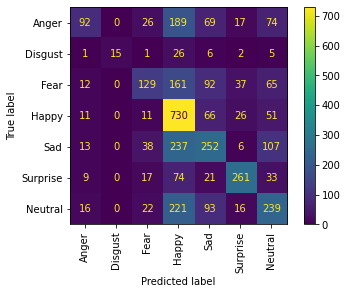

In [ ]:
forest_clf_grid_search = load('models/forest_gridsearch.joblib')
print('the accuracy score on the test data of the best forest estimator found using GridSearchCV is: ' + str(accuracy_score(y_test, forest_clf_grid_search.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the test data of the best forest estimator found using GridSearchCV is: ' + str(balanced_accuracy_score(y_test, forest_clf_grid_search.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the accuracy score on the training data of the best forest estimator found using RandomSearchCV is: ' + str(accuracy_score(y_train, forest_clf_grid_search.best_estimator_.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the training data of the best forest estimator found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_train, forest_clf_grid_search.best_estimator_.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the accuracy score on the validation data of the best forest estimator found using RandomSearchCV is: ' + str(accuracy_score(y_val, forest_clf_grid_search.best_estimator_.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the validation data of the best forest estimator found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_val, forest_clf_grid_search.best_estimator_.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
sklearn.metrics.plot_confusion_matrix(forest_clf_grid_search.best_estimator_, X_test.reshape(X_test.shape[0], -1), y_test, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], xticks_rotation=90);


([], <a list of 0 Text major ticklabel objects>)

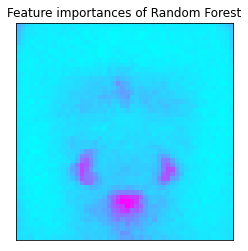

In [ ]:
"""
Plotting the feature importances of the best-performing RandomForestClassifier,
"""
estimator = forest_clf_grid_search.best_estimator_
importances = estimator.feature_importances_
importances = importances.reshape(48, 48)
plt.imshow(importances[:, :], cmap='cool', interpolation='nearest')
plt.title('Feature importances of Random Forest')
#Hide x and y ticks
plt.xticks([])
plt.yticks([])


### Ada Boost with Decision Stump

In [ ]:
Ada_randomSearch = load('models/ada_randomsearch.joblib')
print('the accuracy score on the test data of the highest performing Ada estimator based on n_estimators found using RandomSearchCV is: ' + str(accuracy_score(y_test, Ada_randomSearch.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the test data of the highest performing Ada estimator based on n_estimators found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_test, Ada_randomSearch.best_estimator_.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the accuracy score on the training data of the best Ada estimator based on n_estimators found using RandomSearchCV is: ' + str(accuracy_score(y_train, Ada_randomSearch.best_estimator_.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the training data of the Ada estimator based on n_estimators found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_train, Ada_randomSearch.best_estimator_.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the accuracy score on the validation data of the best Ada estimator based on n_estimators found using RandomSearchCV is: ' + str(accuracy_score(y_val, Ada_randomSearch.best_estimator_.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the validation data of the best Ada estimator based on n_estimators found using RandomSearchCV is: ' + str(balanced_accuracy_score(y_val, Ada_randomSearch.best_estimator_.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');


the accuracy score on the test data of the highest performing Ada estimator based on n_estimators found using RandomSearchCV is: 35.051546391752574%
the balanced accuracy score on the test data of the highest performing Ada estimator based on n_estimators found using RandomSearchCV is: 28.87208397062369%
the accuracy score on the training data of the best Ada estimator based on n_estimators found using RandomSearchCV is: 35.34780034135637%
the balanced accuracy score on the training data of the Ada estimator based on n_estimators found using RandomSearchCV is: 29.71098574810011%
the accuracy score on the validation data of the best Ada estimator based on n_estimators found using RandomSearchCV is: 33.90916689885762%
the balanced accuracy score on the validation data of the best Ada estimator based on n_estimators found using RandomSearchCV is: 28.005001551248434%


the accuracy score on the test data of the best Ada estimator found based on learning-rate hyperparameter search: 37.057676232933964%
the balanced accuracy score on the test data of the best Ada estimator found based on learning-rate hyperparameter search: 30.441654719380633%
the accuracy score on the training data of the best Ada estimator based on learning-rate hyperparameter search: 36.67839353512836%
the balanced accuracy score on the training data of the Ada estimator based on learning-rate hyperparameter search: 29.671659547086985%
the accuracy score on the validation data of the best Ada estimator based on learning-rate hyperparameter search: 35.69239342435219%
the balanced accuracy score on the validation data of the best Ada estimator based on learning-rate hyperparameter search: 28.717346427692753%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


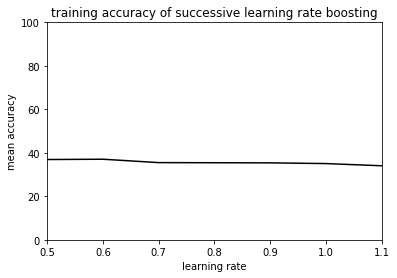

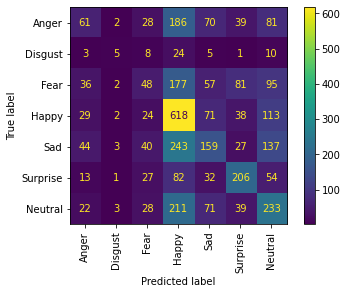

In [ ]:
Ada_boost_clfs = []
for i in range(7):
  Ada_boost_clfs.append(load(''.join(['ada', str(i), '.joblib'])))

learning_rates = np.arange(0.5, 1.2, 0.1)
accuracies = []
for i in range(7):
    accuracies.append(sklearn.metrics.accuracy_score(y_test, Ada_boost_clfs[i].predict(X_test.reshape(X_test.shape[0], -1)))*100)

# Plot the accuracies
plt.plot(learning_rates, accuracies, 'k')
plt.xlim([0.5, 1.1])
plt.ylim([0, 100])
plt.xlabel('learning rate')
plt.ylabel('mean accuracy')
plt.title('training accuracy of successive learning rate boosting')

Ada = load('ideal_ada.joblib')
print('the accuracy score on the test data of the best Ada estimator found based on learning-rate hyperparameter search: ' + str(accuracy_score(y_test, Ada.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the test data of the best Ada estimator found based on learning-rate hyperparameter search: ' + str(balanced_accuracy_score(y_test, Ada.predict(X_test.reshape(X_test.shape[0], -1))) * 100) + '%');
print('the accuracy score on the training data of the best Ada estimator based on learning-rate hyperparameter search: ' + str(accuracy_score(y_train, Ada.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the training data of the Ada estimator based on learning-rate hyperparameter search: ' + str(balanced_accuracy_score(y_train, Ada.predict(X_train.reshape(X_train.shape[0], -1))) * 100) + '%');
print('the accuracy score on the validation data of the best Ada estimator based on learning-rate hyperparameter search: ' + str(accuracy_score(y_val, Ada.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
print('the balanced accuracy score on the validation data of the best Ada estimator based on learning-rate hyperparameter search: ' + str(balanced_accuracy_score(y_val, Ada.predict(X_val.reshape(X_val.shape[0], -1))) * 100) + '%');
sklearn.metrics.plot_confusion_matrix(Ada, X_test.reshape(X_test.shape[0], -1), y_test, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], xticks_rotation=90);


### SVM

In [ ]:
svm_clf = load('models/best_svm.joblib')

X_train_svm = X_train.reshape(X_train.shape[0],-1)
X_val_svm = X_val.reshape(X_val.shape[0],-1)
X_test_svm = X_test.reshape(X_test.shape[0],-1)

scalify = StandardScaler()
X_train_svm = scalify.fit_transform(X_train_svm)
X_val_svm = scalify.transform(X_val_svm)
X_test_svm = scalify.transform(X_test_svm)

In [ ]:
print('Accuracy')
print('Training: ' + str(svm_clf.score(X_train_svm,y_train)))
print('Validation: ' + str(svm_clf.score(X_val_svm,y_val)))
print('Test: ' +  str(svm_clf.score(X_test_svm,y_test)))

print('Balanced Accuracy')
print('Training: ' + str(balanced_accuracy_score(y_train, svm_clf.predict(X_train_svm))))
print('Validation: ' + str(balanced_accuracy_score(y_val, svm_clf.predict(X_val_svm))))
print('Test: ' + str(balanced_accuracy_score(y_test, svm_clf.predict(X_test_svm))))

Accuracy
Training: 0.9470549305095963
Validation: 0.4856505990526609
Test: 0.4831429367511842
Balanced Accuracy
Training: 0.9352714013749175
Validation: 0.47324533837745875
Test: 0.4471086313161901


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


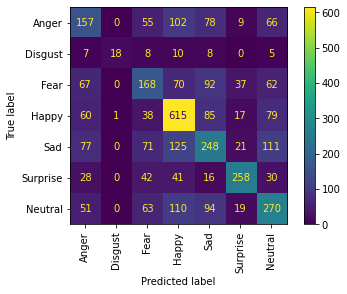

In [ ]:
sklearn.metrics.plot_confusion_matrix(svm_clf, X_test_svm, y_test, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], xticks_rotation=90);

### Linear Neural Network

In [ ]:
nn_clf = load('models/best_nn.joblib')

X_train_nn = X_train.reshape(X_train.shape[0],-1)
X_val_nn = X_val.reshape(X_val.shape[0],-1)
X_test_nn = X_test.reshape(X_test.shape[0],-1)

scalify = StandardScaler()
X_train_nn = scalify.fit_transform(X_train_nn)
X_val_nn = scalify.transform(X_val_nn)
X_test_nn = scalify.transform(X_test_nn)

In [ ]:
print('Accuracy')
print('Training: ' + str(nn_clf.score(X_train_nn,y_train)))
print('Validation: ' + str(nn_clf.score(X_val_nn,y_val)))
print('Test: ' +  str(nn_clf.score(X_test_nn,y_test)))

print('Balanced Accuracy')
print('Training: ' + str(balanced_accuracy_score(y_train, nn_clf.predict(X_train_nn))))
print('Validation: ' + str(balanced_accuracy_score(y_val, nn_clf.predict(X_val_nn))))
print('Test: ' + str(balanced_accuracy_score(y_test, nn_clf.predict(X_test_nn))))

Accuracy
Training: 0.9745027691664635
Validation: 0.4594594594594595
Test: 0.45834494288102534
Balanced Accuracy
Training: 0.9728438863733748
Validation: 0.445683837502216
Test: 0.4448590476574836


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


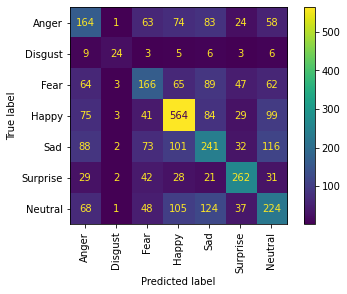

In [ ]:
sklearn.metrics.plot_confusion_matrix(nn_clf, X_test_nn, y_test, display_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], xticks_rotation=90);

In [ ]:
weight = nn_clf.coefs_
weight = weight[0].T.reshape(400,48,48)

(-0.5, 47.5, 47.5, -0.5)

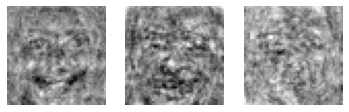

In [ ]:
#03
plt.subplot(1,3,1)
plt.imshow(weight[0], cmap = 'gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(weight[3], cmap = 'gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(weight[1], cmap = 'gray')
plt.axis('off')

### Convolutional Neural Network

In [ ]:
from keras.models import load_model
model2 = load_model("models/cnn_model.hdf5")

In [ ]:
Xtrain = X_train.reshape(28709, 48, 48, 1)
Xtest = X_test.reshape(3589, 48, 48, 1)
Xval = X_test.reshape(3589, 48, 48, 1)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 7)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 7)

In [ ]:
#Normalization
Xtrain1 = Xtrain/255.
Xtest1 = Xtest/255. 
Xval1 = Xval/255.

In [ ]:
model2.evaluate(X_test, y_test)
model2.evaluate(X_train, y_train)
model2.evaluate(X_val, y_val)


113/113 [==============================] - 2s 21ms/step - loss: 1.3432 - accuracy: 0.5099


[1.3431614637374878, 0.5098913311958313]

No handles with labels found to put in legend.


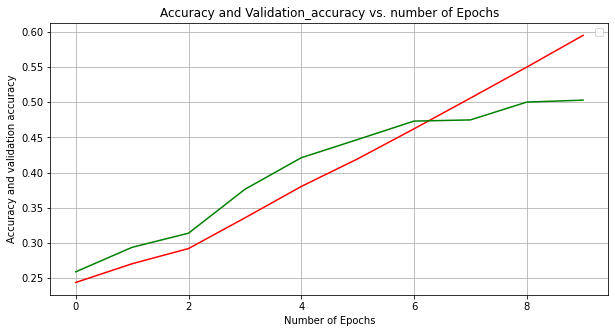

In [ ]:
from matplotlib import pyplot as plt
plt.title("Accuracy and Validation_accuracy vs. number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy and validation accuracy")
plt.plot(model.history['accuracy'],'r')
plt.plot(model.history['val_accuracy'],'g')
plt.legend()
plt.grid()


### SVM HOG

In [ ]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(2,2), 
    orientations=8, 
    block_norm='L2-Hys'
)

scalify = StandardScaler()

svm_clf_hog = load('models/best_svm_hog.joblib')

In [ ]:
X_train_hog = hogify.fit_transform(X_train)
X_train_ready = scalify.fit_transform(X_train_hog)

X_val_hog = hogify.transform(X_val)
X_val_ready = scalify.transform(X_val_hog)

X_test_hog = hogify.transform(X_test)
X_test_ready = scalify.transform(X_test_hog)

In [ ]:
print('Accuracy')
print('Training: ' + str(svm_clf_hog.score(X_train_ready,y_train)))
print('Validation: ' + str(svm_clf_hog.score(X_val_ready,y_val)))
print('Test: ' +  str(svm_clf_hog.score(X_test_ready,y_test)))

print('Balanced Accuracy')
print('Training: ' + str(balanced_accuracy_score(y_train, svm_clf_hog.predict(X_train_ready))))
print('Validation: ' + str(balanced_accuracy_score(y_val, svm_clf_hog.predict(X_val_ready))))
print('Test: ' + str(balanced_accuracy_score(y_test, svm_clf_hog.predict(X_test_ready))))

Accuracy
Training: 0.9980145598941098
Validation: 0.5739760378935637
Test: 0.5678461967121761
Balanced Accuracy
Training: 0.997755844675378
Validation: 0.5567746133135569
Test: 0.5362953694821083


### Linear Neural Network HOG

In [ ]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(2,2), 
    orientations=8, 
    block_norm='L2-Hys'
)

scalify = StandardScaler()

nn_clf_hog = load('models/best_nn_hog.joblib')

In [ ]:
X_train_hog = hogify.fit_transform(X_train)
X_train_ready = scalify.fit_transform(X_train_hog)

X_val_hog = hogify.transform(X_val)
X_val_ready = scalify.transform(X_val_hog)

X_test_hog = hogify.transform(X_test)
X_test_ready = scalify.transform(X_test_hog)

In [ ]:
print('Accuracy')
print('Training: ' + str(nn_clf_hog.score(X_train_ready,y_train)))
print('Validation: ' + str(nn_clf_hog.score(X_val_ready,y_val)))
print('Test: ' +  str(nn_clf_hog.score(X_test_ready,y_test)))

print('Balanced Accuracy')
print('Training: ' + str(balanced_accuracy_score(y_train, nn_clf_hog.predict(X_train_ready))))
print('Validation: ' + str(balanced_accuracy_score(y_val, nn_clf_hog.predict(X_val_ready))))
print('Test: ' + str(balanced_accuracy_score(y_test, nn_clf_hog.predict(X_test_ready))))

Accuracy
Training: 0.9838029886098436
Validation: 0.5043187517414321
Test: 0.5045973808860407
Balanced Accuracy
Training: 0.9827494251462052
Validation: 0.48591734780934376
Test: 0.4934676695574926


### Final Results

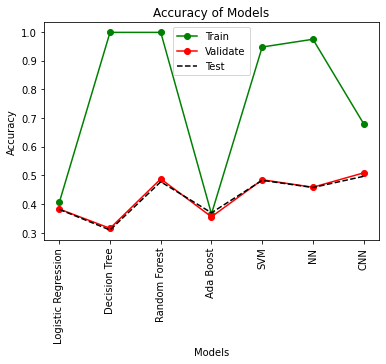

In [ ]:
model_labels = ['Logistic Regression','Decision Tree','Random Forest', 'Ada Boost', 'SVM', 'NN', 'CNN']
train_results_acc = [0.406, 0.998, 0.998, 0.366, 0.947, 0.974, 0.680]
val_results_acc = [0.383, 0.316, 0.488, 0.356, 0.485, 0.459, 0.509]
test_results_acc = [0.382, 0.310, 0.478, 0.370, 0.483, 0.458, 0.497]

x_axis = np.arange(0,7)

plt.title('Accuracy of Models')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(x_axis, model_labels, rotation='vertical')

plt.plot(x_axis, train_results_acc, '-go', label = 'Train')
plt.plot(x_axis, val_results_acc, '-ro', label = 'Validate')
plt.plot(x_axis, test_results_acc, '--k', label = 'Test')

plt.legend()
plt.show()

Text(0.9, 0.524, '0.504')

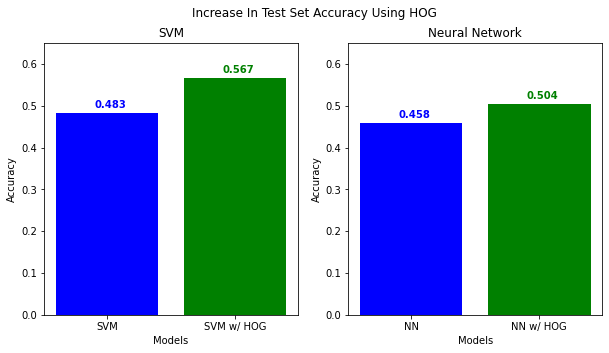

In [ ]:
model_labels_SVM=['SVM', 'SVM w/ HOG']
model_labels_NN=['NN', 'NN w/ HOG']
SVM_results = [0.483, 0.567]
NN_results = [0.458, 0.504]

x_axis = np.arange(0,2)

f = plt.figure(figsize=(10,5))
f.add_subplot(1,2,1)
plt.suptitle('Increase In Test Set Accuracy Using HOG')
plt.title('SVM')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(x_axis, model_labels_SVM)
plt.bar(x_axis, SVM_results, color = ['blue', 'green'])
plt.ylim([0,0.65])
plt.text(0 - 0.1, SVM_results[0] + 0.02, str(SVM_results[0]), color='blue', va='center', fontweight='bold')
plt.text(1 - 0.1, SVM_results[1] + 0.02, str(SVM_results[1]), color='green', va='center', fontweight='bold')

f.add_subplot(1,2,2)
plt.title('Neural Network')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(x_axis, model_labels_NN)
plt.bar(x_axis, NN_results, color = ['blue', 'green'])
plt.ylim([0,0.65])
plt.text(0 - 0.1, NN_results[0] + 0.02, str(NN_results[0]), color='blue', va='center', fontweight='bold')
plt.text(1 - 0.1, NN_results[1] + 0.02, str(NN_results[1]), color='green', va='center', fontweight='bold')

## Training

- Below is the code to train the models as it was done in the project.
- You can run them to get the same models .
- <font color = "red"> __Warning they all take very long to finish training__</font>
- Note: The models might not be able to be trained one after the other as the training data could be transformed and would need to be reset. 

### Logistic Regression

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [ ]:
params = {'C': scipy.stats.reciprocal(1e-5,1.0)}
clf = sklearn.linear_model.LogisticRegression(max_iter=10000,random_state = 0)

In [ ]:
linear_clf = sklearn.model_selection.RandomizedSearchCV(clf, params, verbose=1, random_state=0).fit(X_train,y_train)

### K-Means

In [ ]:
#K-MEANS imports
import sklearn.cluster   
import mpl_toolkits.mplot3d    
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Checking the minimum and maximum values of x_train
print(X_train.min())
print(X_train.max())

# Data Normalization

# Conversion to float
X_train2 = X_train.astype("float32") 
X_test2 = X_test.astype("float32")
X_val2 = X_val.astype("float32")

# Normalization
X_train2 = X_train2/255.0
X_test2 = X_test2/255.0
X_val2 = X_val2/255.0

# Checking the minimum and maximum values of x_train
print(X_train2.min())
print(X_train2.max())

0.0
255.0
0.0
1.0


3D -> 2D The input data have to be converted from 3 dimensional format to 2 dimensional format to be fed into the K-Means Clustering algorithm.

In [ ]:
# Reshaping input data
x_train2 = X_train2.reshape(len(X_train2),-1)
x_test2 = X_test2.reshape(len(X_test2),-1)
x_val2 = X_val2.reshape(len(X_val2),-1)

In [ ]:
print(x_train2.shape)
print(x_test2.shape)
print(x_val2.shape) #2304 dimensions! Absurd

(28709, 2304)
(3589, 2304)
(3589, 2304)


In [ ]:
ssd=[];score=[]
for k in range(2,10):
    Kmeans=KMeans(n_clusters=k,random_state=4)
    Kmeans.fit(x_train2)
    ssd.append(Kmeans.inertia_)
    ss=silhouette_score(x_train2,Kmeans.labels_)
    score.append(ss)

In [ ]:
print(score)

[0.16288863, 0.10109221, 0.10010595, 0.09842205, 0.08044286, 0.07383268, 0.07112734, 0.06956878]


In [ ]:
print(ssd)

[3301376.5, 3080706.0, 2930448.5, 2820657.5, 2749390.5, 2695391.5, 2646577.5, 2605383.0]


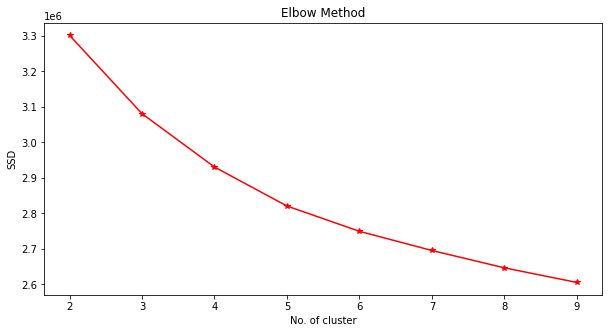

In [ ]:
# elbow plot
plt.rcParams['figure.figsize']=[10,5]
plt.plot(range(2,10),ssd,marker='*',color='r')
plt.title("Elbow Method")
plt.xlabel('No. of cluster')
plt.ylabel('SSD')
plt.show()


### Kernel Density

In [ ]:
# Reshape the data into two dim in order to be able to fit
X_train = X_train.reshape(X_train.shape[0], -1) 
#Reduce size
X_train = X_train/255 
kde = KernelDensity(kernel='tophat', bandwidth=0.2).fit(X_train)

### Gaussian Mixtures

In [ ]:
# Reshape the data into two dim in order to be able to fit
X_train = X_train.reshape(X_train.shape[0], -1) 
#Reduce size
X_train = X_train/255 
#Train with attempt to group into 9 cluster
gmm = sklearn.mixture.GaussianMixture(n_components=7, random_state=0, n_init=4)
gmm = gmm.fit(X_train, y_train);

### Decision Tree

In [ ]:
# Reshape the data into two dim in order to be able to fit
X_train = X_train.reshape(X_train.shape[0], -1)
# Define params to be searched over
params = {'max_depth': scipy.stats.reciprocal(10, 100)}
# train a decision tree model on the params
tree_clf = sklearn.tree.DecisionTreeClassifier()
grid_search = sklearn.model_selection.RandomizedSearchCV(tree_clf, params, verbose=1, random_state=0)
grid_search.fit(X_train, y_train)

### Random Forest

In [ ]:
params = {'n_estimators' : np.logspace(4, 9, base = 2, num = 6, dtype=int), 'max_depth' : np.arange(10, 130, 25)}
forest_clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
forest_grid_search = sklearn.model_selection.GridSearchCV(forest_clf, params, verbose=1)
forest_grid_search.fit(X_train, y_train)

### Ada Boost with Decision Stump

In [ ]:
Ada = sklearn.ensemble.AdaBoostClassifier(random_state=0)
# Find best n_estimators for AdaBoost
params = {'n_estimators': np.logspace(1, 2.5, num=10, dtype=int)}
ada_grid_search = sklearn.model_selection.RandomizedSearchCV(Ada, params, verbose=1, random_state=0)
ada_grid_search.fit(X_train, y_train)

In [ ]:
# Try different learning rates on the AdaBoost classifier that had the optimal number of estimators:
scores = []
AdaBoost_classifiers = []
learning_rates = np.arange(0.5, 1.2, 0.1)
for rate in learning_rates:
  Ada = sklearn.ensemble.AdaBoostClassifier(random_state=0, n_estimators=316, learning_rate=rate)
  Ada.fit(X_train.reshape(X_train.shape[0], -1), y_train)
  AdaBoost_classifiers.append(Ada)
  scores.append(Ada.score(X_test.reshape(X_test.shape[0], -1), y_test))

### SVM

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
scalify = StandardScaler()
X_train = scalify.fit_transform(X_train)
X_val = scalify.transform(X_val)
X_test = scalify.transform(X_test)

In [ ]:
svm_estimators = train_estimators(X_train, y_train, sklearn.svm.SVC,
                                   'C', [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], max_iter = 10000 ,random_state=0)

In [ ]:
params = {'C': scipy.stats.reciprocal(0.01,1000.0)}
clf = sklearn.svm.SVC(max_iter=10000,random_state = 0)
search = sklearn.model_selection.RandomizedSearchCV(clf, params, verbose=1, random_state=0, n_iter= 5, cv= 2).fit(X_train,y_train)

### Linear Neural Network

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
scalify = StandardScaler()
X_train = scalify.fit_transform(X_train)
X_val = scalify.transform(X_val)
X_test = scalify.transform(X_test)

In [ ]:
nn = sklearn.neural_network.MLPClassifier(hidden_layer_sizes = (400,200,100,50), activation = 'relu',solver = 'adam', learning_rate_init = 0.001, max_iter = 200, random_state = 0, verbose = True).fit(X_train, y_train)

### Convolutional Neural Network

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(28709, 48, 48)
(3589, 48, 48)
(3589, 48, 48)


In [ ]:
Xtrain = X_train.reshape(28709, 48, 48, 1) #CNN takes 3D images only
Xtest = X_test.reshape(3589, 48, 48, 1)
Xval = X_test.reshape(3589, 48, 48, 1)

In [ ]:
import tensorflow as tf

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 7)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)
y_val = tf.keras.utils.to_categorical(y_val, num_classes = 7)

In [ ]:
#Normalization
Xtrain1 = Xtrain/255. #all pixels range from 0-255 in grey 0-back 255-white
Xtest1 = Xtest/255. #Point is to put everything in float
Xval1 = Xval/255.

In [ ]:
print(Xtrain1.shape)
print(Xtest1.shape)
print(Xval1.shape)
print(y_val.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 7)
(28709, 7)
(3589, 7)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers, optimizers

In [ ]:
#CNN IMPLEMENTATION (Convolution -> understand FEAUTURES of each images + NN)
cnn = Sequential()
cnn.add(Conv2D(32,(3,3),activation = "relu", input_shape = (48, 48, 1))) #applying 32 kernels (kernel size 3X3)
cnn.add(MaxPooling2D(pool_size = (2, 2))) #avg information
cnn.add(Dropout(0.2)) #to deal with overfitting

cnn.add(Conv2D(32,(3,3),activation = "relu")) #relu helps avoid negative valies (validates)
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Dropout(0.2))
cnn.add(Flatten()) #2D turns to 1D (48,48,1) 2304 number of neurons
cnn.add(Dense(units = 256, activation = "relu"))

cnn.add(Dense(units = 64, activation = "relu"))

cnn.add(Dense(units = 7, activation = "softmax")) #Because we have 7 classes

In [ ]:
cnn.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
model = cnn.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, validation_data = (X_test, y_test))

Epoch 1/10
898/898 [==============================] - 80s 87ms/step - loss: 2.2508 - accuracy: 0.2437 - val_loss: 1.7996 - val_accuracy: 0.2588
Epoch 2/10
898/898 [==============================] - 78s 87ms/step - loss: 1.7804 - accuracy: 0.2703 - val_loss: 1.7446 - val_accuracy: 0.2937
Epoch 3/10
898/898 [==============================] - 78s 87ms/step - loss: 1.7368 - accuracy: 0.2919 - val_loss: 1.7019 - val_accuracy: 0.3137
Epoch 4/10
898/898 [==============================] - 77s 85ms/step - loss: 1.6730 - accuracy: 0.3355 - val_loss: 1.6043 - val_accuracy: 0.3761
Epoch 5/10
898/898 [==============================] - 76s 85ms/step - loss: 1.5872 - accuracy: 0.3802 - val_loss: 1.5398 - val_accuracy: 0.4210
Epoch 6/10
898/898 [==============================] - 76s 84ms/step - loss: 1.5001 - accuracy: 0.4194 - val_loss: 1.4531 - val_accuracy: 0.4469
Epoch 7/10
898/898 [==============================] - 75s 83ms/step - loss: 1.3989 - accuracy: 0.4621 - val_loss: 1.3975 - val_accuracy:

In [ ]:
from keras.models import load_model
model2 = load_model("/content/drive/MyDrive/cnn_model.hdf5")

In [ ]:
model2.evaluate(X_test, y_test)
model2.evaluate(X_train, y_train)
model2.evaluate(X_val, y_val)

113/113 [==============================] - 2s 20ms/step - loss: 1.3432 - accuracy: 0.5099


[1.3431614637374878, 0.5098913311958313]

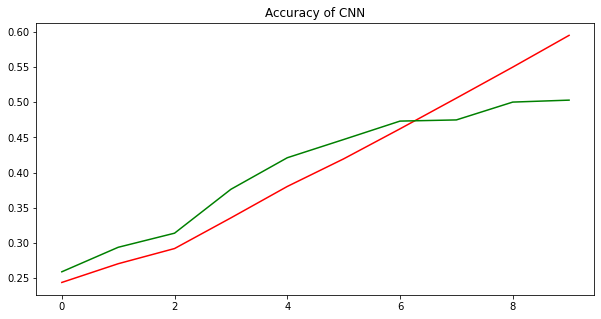

In [ ]:
from matplotlib import pyplot as plt
plt.title("Accuracy of CNN")
plt.plot(model.history['accuracy'],'r')
plt.plot(model.history['val_accuracy'],'g')


### SVM w/ HOG

In [ ]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(2,2), 
    orientations=8, 
    block_norm='L2-Hys'
)

scalify = StandardScaler()

In [ ]:
X_train_hog = hogify.fit_transform(X_train)
X_train_ready = scalify.fit_transform(X_train_hog)

In [ ]:
clf = sklearn.svm.SVC(C=5.547119471592124, max_iter=10000, random_state=0).fit(X_train_ready,y_train)

### Linear Neural Network w/ HOG

In [ ]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(2,2), 
    orientations=8, 
    block_norm='L2-Hys'
)

scalify = StandardScaler()

In [ ]:
X_train_hog = hogify.fit_transform(X_train)

In [ ]:
X_train_ready = scalify.fit_transform(X_train_hog)

In [ ]:
nn = sklearn.neural_network.MLPClassifier(hidden_layer_sizes = (400,200,100,50), activation = 'relu',solver = 'adam', learning_rate_init = 0.001, max_iter = 200, random_state = 0, verbose = True).fit(X_train_ready, y_train)

## Attempts to fix over fitting

- Attemps to fix overfirritng for SVM and Linear Neural Network were made but with insignificant chages
- You can run them below to see
- <font color = "red"> __Warning they take very long to finish training__</font>

### NN

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
scalify = StandardScaler()
X_train = scalify.fit_transform(X_train)
X_val = scalify.transform(X_val)
X_test = scalify.transform(X_test)

In [ ]:
nn = sklearn.neural_network.MLPClassifier(hidden_layer_sizes = (400,200,100,50), activation = 'relu',solver = 'adam', learning_rate_init = 0.001, max_iter = 100, random_state = 0)

clf = BaggingClassifier(base_estimator=nn,n_estimators=10, random_state=0, verbose=True).fit(X_train, y_train)

### SVM

In [ ]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
scalify = StandardScaler()
X_train = scalify.fit_transform(X_train)
X_val = scalify.transform(X_val)
X_test = scalify.transform(X_test)

In [ ]:
params = {'C': scipy.stats.reciprocal(0.01,1000.0)}
clf = sklearn.svm.SVC(max_iter=10000,random_state = 0)
search = sklearn.model_selection.RandomizedSearchCV(clf, params, verbose=1, random_state=0, n_iter= 5, cv= 2).fit(X_train,y_train)